In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

from scipy.special import logit
from scipy.stats import norm

# Constants

In [9]:
DATA_PATH = '/kaggle/input/ad-clicks/data.csv'

# Feature engineering

In [10]:
def feature_engineering(data_path) -> pd.DataFrame:
    data = pd.read_csv(data_path, parse_dates=["date_time"])

    # delete outlier
    data = data[data.date_time > "2021-09-26"]

    # add day_of_week and hour features
    data['day'] = data['date_time'].dt.day_of_week
    data['hour'] = data['date_time'].dt.hour

    # remove cols
    cols_to_remove = ["campaign_clicks", "oaid_hash", "impressions", "rate0", "rate1"]
    data.drop(cols_to_remove, axis=1, inplace=True)

    # drop duplicates
    data.drop_duplicates(inplace=True)

    # delete NaN
    data.drop(data[data.isna().any(axis=1)].index, inplace=True)

    # delete if banner_id != banner_id0
    data = data[data["banner_id"] == data["banner_id0"]]

    # add interactions
    data['banner_id/os_id'] = data['banner_id'].astype(str) + '/' + data['os_id'].astype(str)
    data['banner_id/zone_id'] = data['banner_id'].astype(str) + '/' + data['zone_id'].astype(str)

    data.reset_index(drop=True, inplace=True)

    return data

engineered_data = feature_engineering(DATA_PATH)
engineered_data.head()

,date_time,zone_id,banner_id,os_id,country_id,banner_id0,g0,coeff_sum0,banner_id1,g1,coeff_sum1,clicks,day,hour,banner_id/os_id,banner_id/zone_id
0,2021-09-26 22:54:49,1,1,0,1,1,0.054298,-2.657477,269,0.031942,-4.449220,1,6,22,1/0,1/1
1,2021-09-26 23:57:20,2,2,0,0,2,0.014096,-3.824875,21,0.014906,-3.939309,1,6,23,2/0,2/2
2,2021-09-27 00:04:30,3,3,1,1,3,0.015232,-3.461357,99,0.050671,-3.418403,1,0,0,3/1,3/3
3,2021-09-27 00:06:21,4,4,1,0,4,0.051265,-4.009026,11464230,0.032005,-2.828797,1,0,0,4/1,4/4
4,2021-09-27 00:06:50,5,5,2,2,5,0.337634,-3.222757,37,0.338195,-3.221755,1,0,0,5/2,5/5


# Analysis

### Посмотрим распределение **по дням**

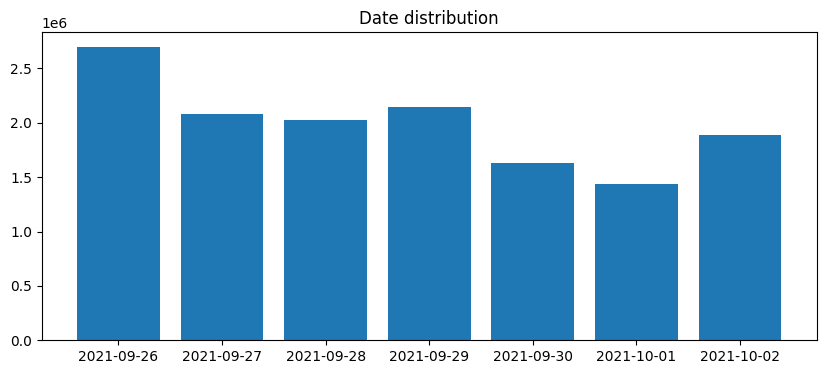

In [11]:
data = engineered_data
date_counts = data['date_time'].groupby(data['date_time'].dt.date).count()
date_names = date_counts.index.values
y = date_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Date distribution')
plt.bar(bins, height=y)
plt.xticks(bins, date_names)
plt.show()

### Посмотрим распределение **по часам**

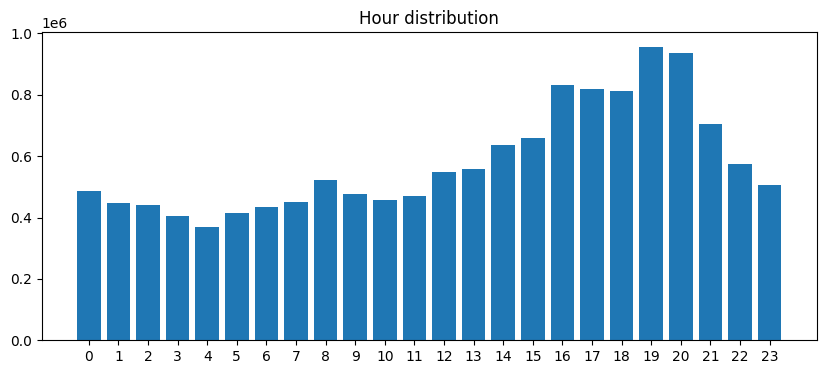

In [12]:
hour_counts = data['date_time'].groupby(data['date_time'].dt.hour).count()
hour_names = hour_counts.index.values
y = hour_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Hour distribution')
plt.bar(bins, height=y)
plt.xticks(bins, hour_names)
plt.show()

In [13]:
def analysis(data: pd.DataFrame):
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id']
    numerical_features = ['g0', 'g1', 'coeff_sum0', 'coeff_sum1']

    print('Unique values:')
    print(data.nunique())

    print('\nnumerical features:')
    for column in numerical_features:
        print(f'{column} min: {data[column].min()}')
        print(f'{column} max: {data[column].max()}')
        print(f'{column} mean: {data[column].mean()}')

    # for col in categorical_features:
    #     data.hist(col)
    #     plt.show()

analysis(data)

Unique values:
date_time              604703
zone_id                  3299
banner_id                1601
os_id                      11
country_id                 17
banner_id0               1601
g0                   13617891
coeff_sum0            4802004
banner_id1            3121226
g1                   13394578
coeff_sum1            5244087
clicks                      2
day                         7
hour                       24
banner_id/os_id          3603
banner_id/zone_id      184352
dtype: int64

numerical features:
g0 min: -0.0176373981227117
g0 max: 691.088787242959
g0 mean: 0.8257769902591875
g1 min: -0.0698389748079466
g1 max: 691.088452897728
g1 mean: 0.577237111140755
coeff_sum0 min: -8.31140713055213
coeff_sum0 max: 0.0
coeff_sum0 mean: -4.078108849494105
coeff_sum1 min: -8.42782707927554
coeff_sum1 max: 0.475618061292297
coeff_sum1 mean: -3.9258635707881386


# Prepare data

In [19]:
class Mapper:
    def __init__(self):
        self.mapper = dict()
        self.unknown_idx = 0
        self.curr_idx = 1

    def fit(self, arr):
        for elem in arr:
            if elem not in self.mapper:
                self.mapper[elem] = self.curr_idx
                self.curr_idx += 1

    def transform(self, arr):
        return np.array([self.mapper[elem] if elem in self.mapper else self.unknown_idx for elem in arr])

    def fit_transform(self, arr):
        self.fit(arr)
        return self.transform(arr)


def prepare_data(data):
    data = data.copy()

    # delete negative g0 and g1 as we are going to use them as std
    data.drop(data[(data['g0'] < 0) & (data['g1'] < 0)].index, inplace=True)

    # get train-test indices
    last_day = data.date_time.max().date()
    train_index = data[data.date_time.dt.date < last_day].index
    test_index = data[data.date_time.dt.date == last_day].index
    
    # drop date_time column
    data = data.drop(['date_time'], axis=1)
    
    # train-test split
    train_data = data.loc[train_index]
    test_data = data.loc[test_index]

    # vectorize features
    mapper_banner_os = Mapper()
    train_data['banner_id/os_id'] = mapper_banner_os.fit_transform(train_data['banner_id/os_id'].values)
    test_data['banner_id/os_id'] = mapper_banner_os.transform(test_data['banner_id/os_id'].values)

    mapper_banner_zone = Mapper()
    train_data['banner_id/zone_id'] = mapper_banner_zone.fit_transform(train_data['banner_id/zone_id'].values)
    test_data['banner_id/zone_id'] = mapper_banner_zone.transform(test_data['banner_id/zone_id'].values)
    
    # ips data
    ips_data = test_data[["g0", "g1", "coeff_sum0", "coeff_sum1"]]

    # delete features which are not used for prediction
    train_data = train_data.drop(['coeff_sum0', 'coeff_sum1', 'g0', 'g1', 'banner_id0', 'banner_id1'],axis=1)
    test_data_pi0 = test_data.drop(['coeff_sum0', 'coeff_sum1', 'g0', 'g1', 'banner_id0', 'banner_id1'],axis=1)

    test_data_pi1 = test_data.drop(['coeff_sum0', 'coeff_sum1', 'g0', 'g1', 'banner_id0', 'banner_id'],axis=1)
    test_data_pi1['banner_id'] = test_data_pi1['banner_id1']
    test_data_pi1 = test_data_pi1.drop('banner_id1', axis=1)

    # features
    X_train = train_data.drop(['clicks'], axis=1).values
    X_test_pi0 = test_data_pi0.drop(['clicks'], axis=1).values
    X_test_pi1 = test_data_pi1.drop(['clicks'], axis=1).values

    # target
    y_train = train_data['clicks'].values
    y_test = test_data['clicks'].values

    return (X_train, y_train), (X_test_pi0, X_test_pi1, y_test), mapper_banner_os, mapper_banner_zone, ips_data


(X_train, y_train), (X_test_pi0, X_test_pi1, y_test), _, _, ips_data = prepare_data(engineered_data)

print(f'features:        {X_train.shape[1]}\n')

print(f'train size:      {len(y_train)}')
print(f'test size:       {len(y_test)}\n')

features:        8

train size:      12026090
test size:       1883622



# Train

In [21]:
model = LogisticRegression(penalty='l2', solver='liblinear', C=0.01, random_state=1234)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=1234, solver='liblinear')

# Perfomance

In [22]:
y_pred = model.predict_proba(X_test_pi0)[:,1]
print('model performance:')
print(f'log loss: {log_loss(y_test, y_pred)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')

model performance:
log loss: 0.15134666611787428
roc_auc_score: 0.6746760142719805


# CIPS

In [29]:
def calc_CIPS(X_test_pi0, X_test_pi1, ips_data, lambda_=10):
    def get_proba(a1, s1, a2, s2):
        return 1 - norm.cdf(0, loc=a1-a2, scale=np.sqrt(s1**2 + s2**2) + 1e-3)   

    probs0 = model.predict_proba(X_test_pi0)[:, 1]
    new_mean0 = logit(probs0)

    probs1 = model.predict_proba(X_test_pi1)[:, 1]
    new_mean1 = logit(probs1)

    pi0 = get_proba(ips_data['coeff_sum0'], 
                    ips_data['g0'],
                    ips_data['coeff_sum1'],
                    ips_data['g1'])

    pi1 = get_proba(new_mean0,
                    ips_data['g0'], 
                    new_mean1,
                    ips_data['g1'])

    CIPS = np.mean(y_test * np.clip(pi1/(pi0+1e-3), a_min=None, a_max=lambda_))

    return CIPS

CIPS = calc_CIPS(X_test_pi0, X_test_pi1, ips_data)
print(f"CIPS: {CIPS}")

CIPS: 0.09309096065244435
